<a href="https://colab.research.google.com/github/Ansalgadulu/Deep-Learning/blob/main/Ninjakart_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

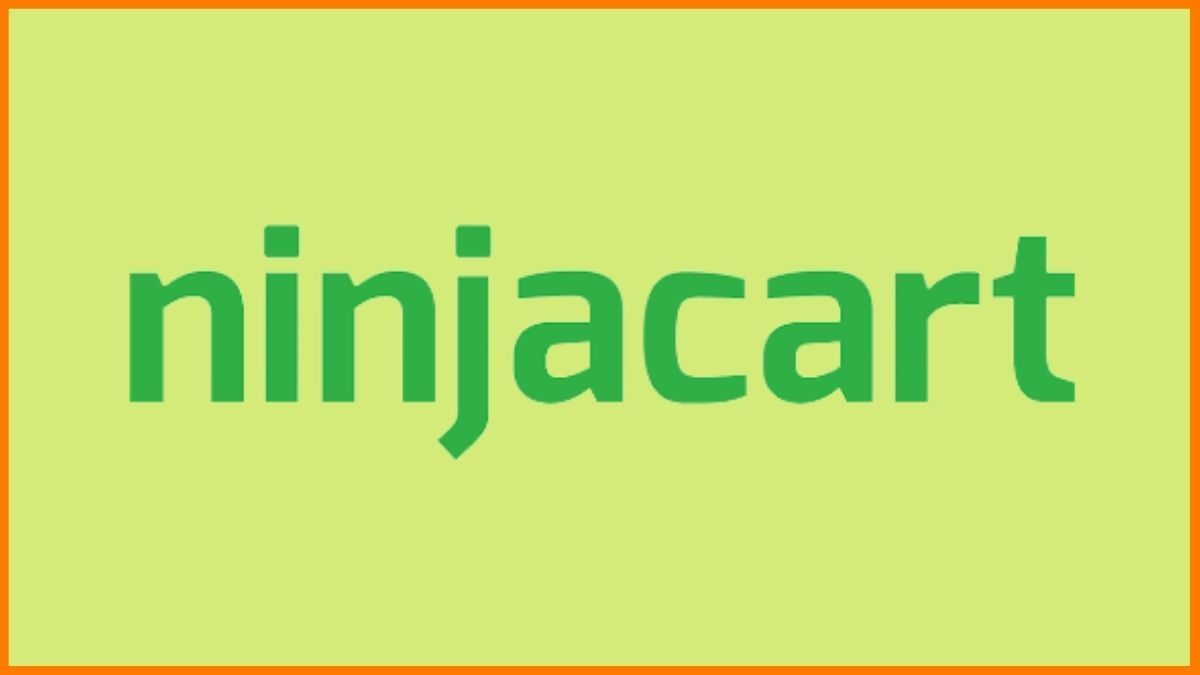

Ninjacart is India's largest fresh produce supply chain company. They are pioneers in solving one of the toughest supply chain problems of the world by leveraging innovative technology. They source fresh produce from farmers and deliver them to businesses within 12 hours. An integral component of their automation process is the development of robust classifiers which can distinguish between images of different types of vegetables, while also correctly labeling images that do not contain any one type of vegetable as noise.


This dataset contains images of the following food items: noise-Indian market and images of vegetables- onion, potato and tomato.

This dataset contains a folder train, which has a total of 3135 images, split into four folders as follows:
1.  Tomato : 789
2.  Potato : 898
3.  Onion : 849
4.  Indian market : 599


This dataset contains another folder test which has a total of 351 images, split into four folders
1.  Tomato : 106
2.   potato : 83
3.   onion : 81
4.   Indian market : 81.

#Library import ,loading data and division of test , train and validation

In [ ]:
import zipfile
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten
from keras.applications import MobileNet,ResNet50,VGG16
import random
import os
import shutil
import glob
import pandas as pd

In [ ]:
!gdown "https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT"

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=00a12228-be1d-49c3-bdc6-c7e6f7086f52
To: /content/ninjacart_data.zip
100% 275M/275M [00:06<00:00, 41.1MB/s]


In [ ]:
zip_ref = zipfile.ZipFile('/content/ninjacart_data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
class_dirs = os.listdir("ninjacart_data/train/") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = keras.utils.load_img(image_path)

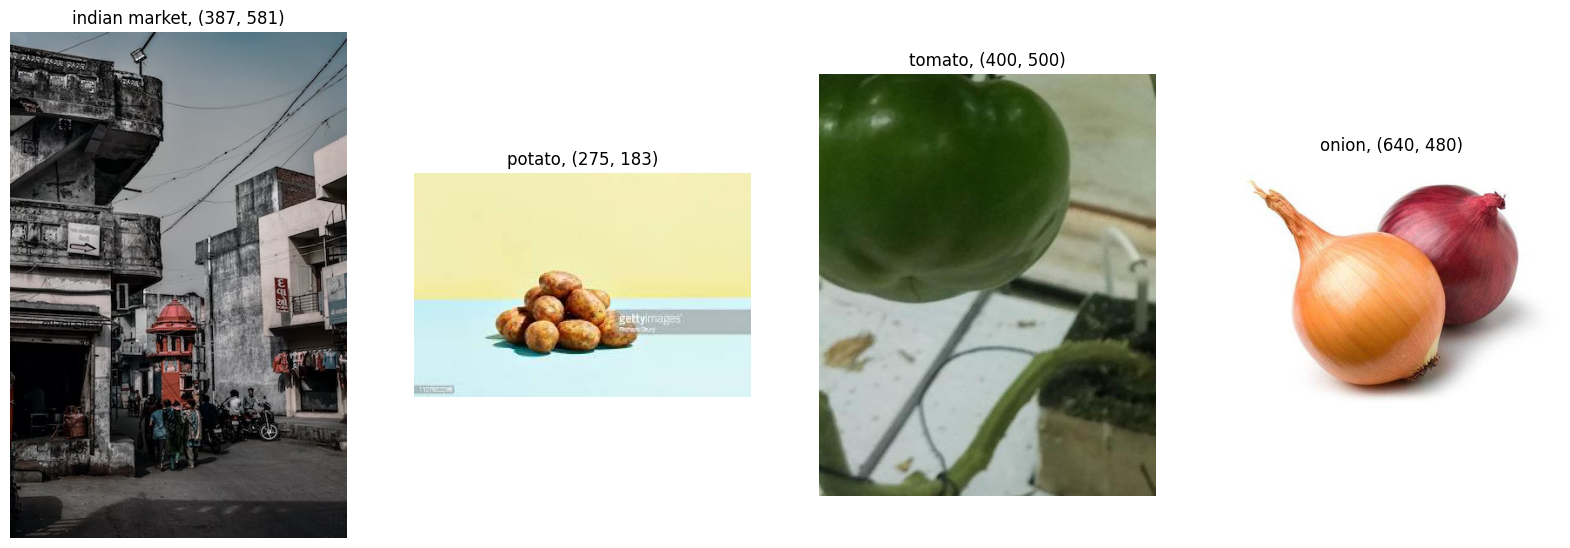

In [ ]:
## Viz Random Sample from each class

plt.figure(figsize=(20, 15))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(1, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
            class  count
0  indian market    599
1         potato    898
2         tomato    789
3          onion    849
total train:3135


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

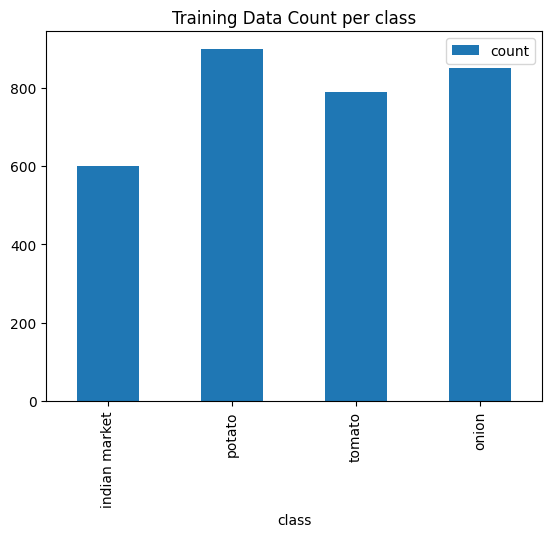

In [ ]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)
print(f"total train:{sum(count_dict.values())}")
# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

There are a total of 4 classes in our train set .
each of the sets have around the same number of labels ranging from 550 -850 approx showing that this is somewhat balanced data set

Count of test samples per class:
            class  count
0  indian market     81
1         potato     81
2         tomato    106
3          onion     83
total test:351


<Axes: title={'center': 'test Data Count per class'}, xlabel='class'>

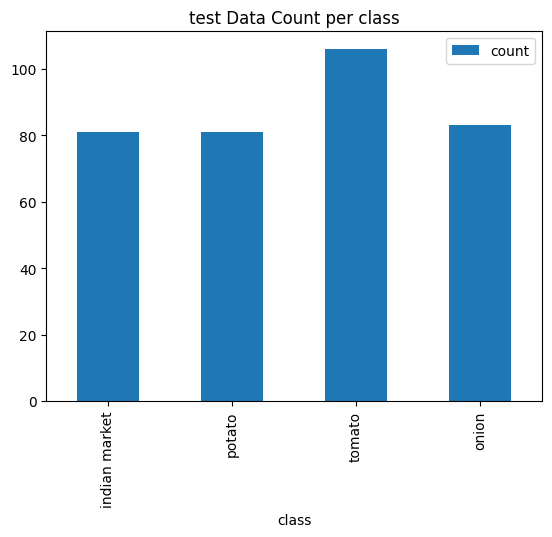

In [ ]:
## Let's now Plot the Data Distribution of Test Data across Classes
class_dirs_test = os.listdir("/content/ninjacart_data/test") # list all directories inside "train" folder
image_dict_test = {} # dict to store image array(key) for every class(value)
count_dict_test = {}
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'ninjacart_data/test/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict_test[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict_test[cls] = keras.utils.load_img(image_path)
df_count_test = pd.DataFrame({
    "class": count_dict_test.keys(),     # keys of count_dict are class labels
    "count": count_dict_test.values(),   # value of count_dict contain counts of each class
})
print("Count of test samples per class:\n", df_count_test)
print(f"total test:{sum(count_dict_test.values())}")

# draw a bar plot using pandas in-built plotting function
df_count_test.plot.bar(x='class', y='count', title="test Data Count per class")


for test we have total of 351 samples and for test  and train we have 3135

In [ ]:
# !rm -r /content/ninjacart_data/train_new
# !rm -r /content/ninjacart_data/validation


In [ ]:

# Set up directories
train_dir = "/content/ninjacart_data/train_new"
validation_dir = "/content/ninjacart_data/validation"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Define split ratio
split_ratio = 0.8  # 80% for training, 20% for validation

# List of class folders
class_folders = [
    "/content/ninjacart_data/train/indian market",
    "/content/ninjacart_data/train/potato",
    "/content/ninjacart_data/train/tomato",
    "/content/ninjacart_data/train/onion"
]

classes = ["indian market", "potato", "tomato", "onion"]

# Create corresponding class folders in train and validation directories
for class_name in classes:
    train_class_dir = os.path.join(train_dir, class_name)
    validation_class_dir = os.path.join(validation_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(validation_class_dir, exist_ok=True)

# Move images to the train and validation sets
for class_folder, class_name in zip(class_folders, classes):
    # Get the list of image files in the current class folder
    image_files = os.listdir(class_folder)

    # Calculate split point
    split_point = int(len(image_files) * split_ratio)

    # Shuffle the image files
    random.shuffle(image_files)

    # Split the images
    train_files = image_files[:split_point]
    validation_files = image_files[split_point:]

    # Move images to the train set
    train_class_dir = os.path.join(train_dir, class_name)
    for file_name in train_files:
        src_path = os.path.join(class_folder, file_name)
        dst_path = os.path.join(train_class_dir, file_name)
        shutil.copy(src_path, dst_path)

    # Move images to the validation set
    validation_class_dir = os.path.join(validation_dir, class_name)
    for file_name in validation_files:
        src_path = os.path.join(class_folder, file_name)
        dst_path = os.path.join(validation_class_dir, file_name)
        shutil.copy(src_path, dst_path)


In [ ]:
len(image_files),len(validation_files),len(train_files)

(849, 170, 679)

# creating data generators to batch load data and preprocessing

In [ ]:
#Data augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#generators
train_ds=train_datagen.flow_from_directory(
    directory="/content/ninjacart_data/train_new",
     class_mode="categorical",
    batch_size=32,
    target_size=(256,256)
)
validation_ds=test_datagen.flow_from_directory(
    directory="/content/ninjacart_data/validation",
    class_mode="categorical",
    batch_size=32,
    target_size=(256,256)
)
test_ds=test_datagen.flow_from_directory(
    directory="/content/ninjacart_data/test",
     class_mode="categorical",
    batch_size=32,
    target_size=(256,256),
    shuffle=False
)

Found 2507 images belonging to 4 classes.
Found 628 images belonging to 4 classes.
Found 351 images belonging to 4 classes.


#Model Training


#Scratch Model

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.dropout(0.4),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.dropout(0.4),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model checkpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(lr_scheduler)

# Fit the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint, lr_schedule]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test accuracy
print('Test Accuracy:', test_accuracy)


Epoch 1/10
79/79 [==============================] - 58s 674ms/step - loss: 1.1333 - accuracy: 0.4914 - val_loss: 0.7338 - val_accuracy: 0.7118 - lr: 0.0010
Epoch 2/10
79/79 [==============================] - 50s 632ms/step - loss: 0.7767 - accuracy: 0.6905 - val_loss: 0.7059 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 3/10
79/79 [==============================] - 50s 639ms/step - loss: 0.6422 - accuracy: 0.7547 - val_loss: 0.6050 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 4/10
79/79 [==============================] - 49s 623ms/step - loss: 0.5826 - accuracy: 0.7822 - val_loss: 0.7121 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 5/10
79/79 [==============================] - 50s 636ms/step - loss: 0.5471 - accuracy: 0.7946 - val_loss: 0.6509 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 6/10
79/79 [==============================] - 62s 792ms/step - loss: 0.5283 - accuracy: 0.7882 - val_loss: 0.5701 - val_accuracy: 0.7611 - lr: 9.0484e-04
Epoch 7/10
79/79 [==============================] - 50s 638m

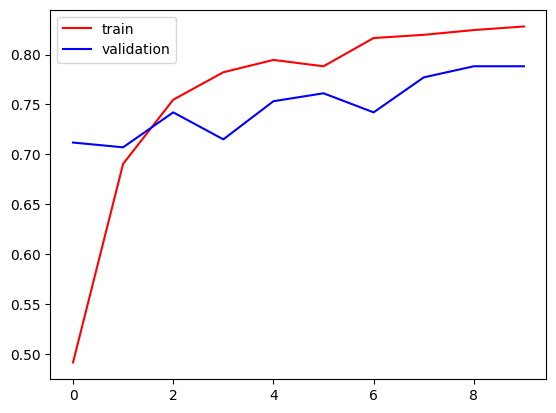

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

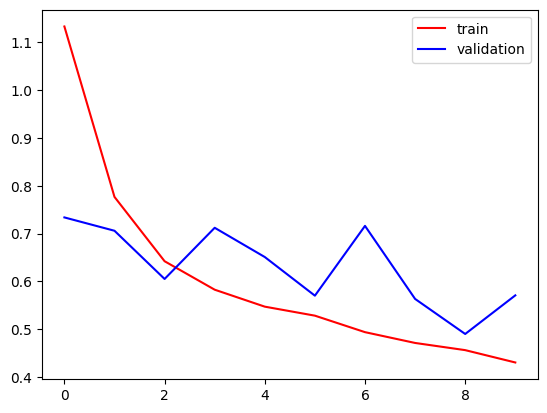

In [ ]:
# loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

#VGG 16

As this is the first model we are training I will go through each steps to make the notebook more explainable


Later I will create a function which trains the model and returns the metrics for the best accuracy model

In [ ]:
feature_extractor = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

feature_extractor.summary()#A summary of our feature extractor layers

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
feature_extractor.layers

In [ ]:
model = Sequential()
# we added 2
model.add(feature_extractor)
model.add(GlobalAveragePooling2D())
model.add(Dense(32,activation='relu'))# we added one dense layer with relu activation to make a base line performance model we can further tune this to achieve better accuracy
model.add(Dense(4,activation='softmax'))# 4 outputs for 4 classes

In [ ]:
model.summary()# our model has 2 extra dense layers after using the vgg16 feature extractor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14,731,236
Trainable params: 14,731,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
feature_extractor.trainable = False #freezing the training for our feature extractor layer

In [ ]:
model.summary()#checking the summary after freezing the first vgg16 feature extractor layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14,731,236
Trainable params: 16,548
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
# Define early stopping callback
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint('best_model_vg16.h5',monitor='val_loss', save_best_only=True)

history = model.fit(train_ds, epochs=30, validation_data=validation_ds, callbacks=[early_stopping, checkpoint])


Epoch 1/30
79/79 [==============================] - 77s 941ms/step - loss: 0.2953 - accuracy: 0.8959 - val_loss: 0.3026 - val_accuracy: 0.9029
Epoch 2/30
79/79 [==============================] - 53s 674ms/step - loss: 0.2751 - accuracy: 0.8995 - val_loss: 0.2756 - val_accuracy: 0.8965
Epoch 3/30
79/79 [==============================] - 54s 681ms/step - loss: 0.2592 - accuracy: 0.9075 - val_loss: 0.2697 - val_accuracy: 0.9013
Epoch 4/30
79/79 [==============================] - 53s 674ms/step - loss: 0.2409 - accuracy: 0.9122 - val_loss: 0.2610 - val_accuracy: 0.8965
Epoch 5/30
79/79 [==============================] - 53s 674ms/step - loss: 0.2293 - accuracy: 0.9194 - val_loss: 0.2902 - val_accuracy: 0.8901
Epoch 6/30
79/79 [==============================] - 53s 673ms/step - loss: 0.2253 - accuracy: 0.9146 - val_loss: 0.2581 - val_accuracy: 0.8997
Epoch 7/30
79/79 [==============================] - 52s 661ms/step - loss: 0.2150 - accuracy: 0.9250 - val_loss: 0.2754 - val_accuracy: 0.8997

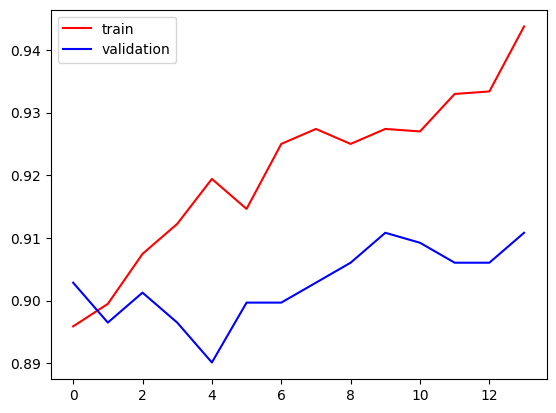

In [ ]:
#Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()



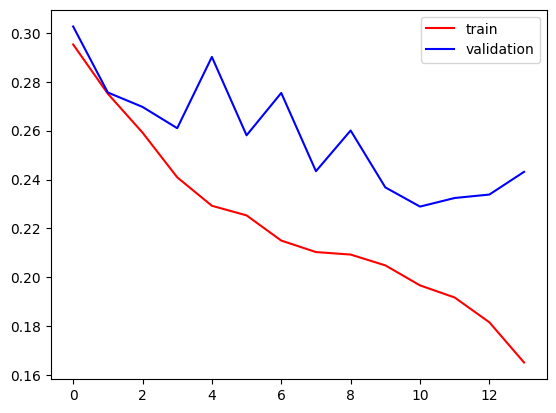

In [ ]:
#loss
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:


# Load the best model
best_model = load_model('best_model_vg16.h5')
# Use the best model for predictions
# Evaluate the best model on the test dataset
loss_test, accuracy_test = best_model.evaluate(test_ds)
loss_val, accuracy_val = best_model.evaluate(validation_ds)
loss_train, accuracy_train = best_model.evaluate(train_ds)

print(f'Test Loss: {loss_test}, Test Accuracy:{accuracy_test}')
print(f'val Loss: {loss_val}, val Accuracy:{accuracy_val}')
print(f'train Loss: {loss_train}, train Accuracy:{accuracy_train}')

79/79 [==============================] - 59s 751ms/step - loss: 0.2968 - accuracy: 0.8899
Test Loss: 0.4348728656768799, Test Accuracy:0.8205128312110901
val Loss: 0.3071072995662689, val Accuracy:0.8773885369300842
train Loss: 0.2968059182167053, train Accuracy:0.8899082541465759


We have acheived 85 % accuracy for test set

the model seems to have overfit
we can try using the below methods to reduce this

1. Regularization: Regularization is a technique used to reduce overfitting in neural networks by adding a penalty term to the loss function. It helps prevent the model from becoming too complex by shrinking the weights of the network, leading to a smoother decision boundary.

2. Dropout layers: Dropout is a regularization technique where random neurons are temporarily ignored or "dropped out" during training. By randomly deactivating neurons, dropout prevents co-adaptation of neurons and reduces overfitting. It forces the network to learn more robust features and enhances generalization.

3. Data augmentation: Data augmentation involves generating new training data by applying various transformations or modifications to existing data samples. These transformations include rotations, translations, flips, zooms, and other operations. Data augmentation increases the size and diversity of the training set, which helps the model generalize better and reduces overfitting.

4. Batch normalization: Batch normalization is a technique that normalizes the activations of each layer in a neural network by subtracting the batch mean and dividing by the batch standard deviation. It helps in reducing the internal covariate shift and provides more stable gradients during training. Batch normalization can prevent overfitting by improving the generalization ability of the model and reducing the dependence on specific weight initializations.


##Creating a function which trains different pre trained models


In [ ]:
def trainmodels(best_model,model_name=VGG16,epochs=20,dense_=16):
  feature_extractor = model_name(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3))
  model = Sequential()
  # we added 2
  model.add(feature_extractor)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(dense_,activation='relu'))# we added one dense layer with relu activation to make a base line performance model we can further tune this to achieve better accuracy
  model.add(Dense(4,activation='softmax'))# 4 outputs for 4 classes
  feature_extractor.trainable = False
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  # Define early stopping callback
  early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

  # Define model checkpoint callback to save the best model during training
  checkpoint = ModelCheckpoint(best_model,monitor='val_loss', save_best_only=True)

  history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[early_stopping, checkpoint])

    #Accuracy
  # plt.plot(history.history['accuracy'],color='red',label='train')
  # plt.plot(history.history['val_accuracy'],color='blue',label='validation')
  # plt.legend()
  # plt.show()
  #   #loss
  # plt.plot(history.history['loss'],color='red',label='train')
  # plt.plot(history.history['val_loss'],color='blue',label='validation')
  # plt.legend()
  # plt.show()
  best = load_model(best_model)
  # Use the best model for predictions
  # Evaluate the best model on the test dataset
  loss_test, accuracy_test = best.evaluate(test_ds)
  loss_val, accuracy_val = best.evaluate(validation_ds)
  loss_train, accuracy_train = best.evaluate(train_ds)

  print(f'Test Loss: {loss_test}, Test Accuracy:{accuracy_test}')
  print(f'val Loss: {loss_val}, val Accuracy:{accuracy_val}')
  print(f'train Loss: {loss_train}, train Accuracy:{accuracy_train}')
  return (best,history)


#Mobile Net

In [ ]:
best_mobile,history_mobile=trainmodels(model_name=MobileNet,best_model="MobileNet_1",epochs=7)

Epoch 4/7
79/79 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9781

79/79 [==============================] - 71s 902ms/step - loss: 0.0675 - accuracy: 0.9781 - val_loss: 0.0915 - val_accuracy: 0.9697
Epoch 5/7
79/79 [==============================] - 59s 751ms/step - loss: 0.0563 - accuracy: 0.9836 - val_loss: 0.1030 - val_accuracy: 0.9666
Epoch 6/7
79/79 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9880

79/79 [==============================] - 61s 770ms/step - loss: 0.0456 - accuracy: 0.9880 - val_loss: 0.0824 - val_accuracy: 0.9666
Epoch 7/7
79/79 [==============================] - 47s 587ms/step - loss: 0.0395 - accuracy: 0.9892
Test Loss: 0.33357957005500793, Test Accuracy:0.8888888955116272
val Loss: 0.08240543305873871, val Accuracy:0.9665604829788208
train Loss: 0.03951619938015938, train Accuracy:0.9892301559448242


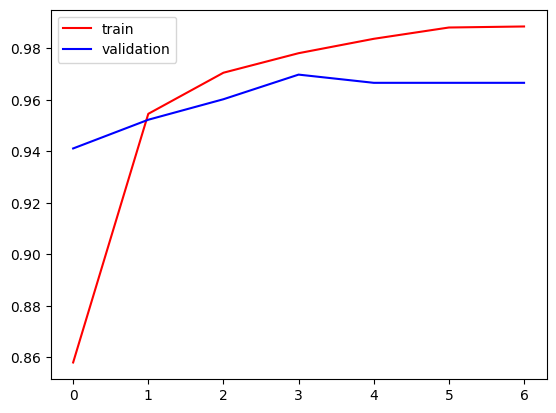

In [ ]:
# Accuracy
plt.plot(history_mobile.history['accuracy'],color='red',label='train')
plt.plot(history_mobile.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

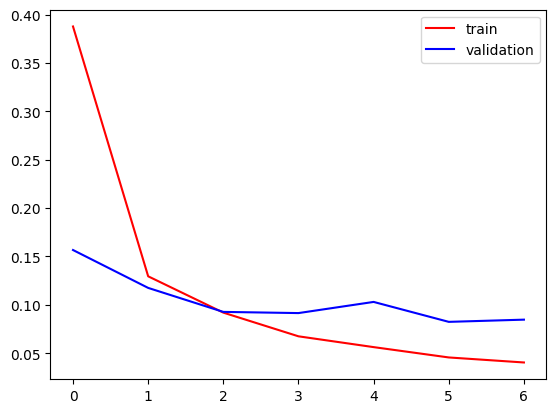

In [ ]:
#loss
plt.plot(history_mobile.history['loss'],color='red',label='train')
plt.plot(history_mobile.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

The model accuracy for mobilenet comes out to be 90.3

#Resnet

In [ ]:
best_resnet,history_resnet=trainmodels(model_name=ResNet50,best_model="Resnet",epochs=7)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/7
79/79 [==============================] - ETA: 0s - loss: 1.3144 - accuracy: 0.3235

79/79 [==============================] - 89s 1s/step - loss: 1.3144 - accuracy: 0.3235 - val_loss: 1.2274 - val_accuracy: 0.3694
Epoch 2/7
79/79 [==============================] - ETA: 0s - loss: 1.2201 - accuracy: 0.4232

79/79 [==============================] - 117s 1s/step - loss: 1.2201 - accuracy: 0.4232 - val_loss: 1.1546 - val_accuracy: 0.5096
Epoch 3/7
79/79 [==============================] - ETA: 0s - loss: 1.1530 - accuracy: 0.4695

79/79 [==============================] - 104s 1s/step - loss: 1.1530 - accuracy: 0.4695 - val_loss: 1.1017 - val_accuracy: 0.5096
Epoch 4/7
79/79 [==============================] - 66s 834ms/step - loss: 1.1199 - accuracy: 0.4759 - val_loss: 1.1095 - val_accuracy: 0.5000
Epoch 5/7
79/79 [==============================] - ETA: 0s - loss: 1.0917 - accuracy: 0.5002

79/79 [==============================] - 77s 984ms/step - loss: 1.0917 - accuracy: 0.5002 - val_loss: 1.0406 - val_accuracy: 0.5541
Epoch 6/7
79/79 [==============================] - ETA: 0s - loss: 1.0562 - accuracy: 0.5313

79/79 [==============================] - 75s 959ms/step - loss: 1.0562 - accuracy: 0.5313 - val_loss: 1.0147 - val_accuracy: 0.5462
Epoch 7/7
79/79 [==============================] - 47s 595ms/step - loss: 1.0374 - accuracy: 0.5305
Test Loss: 1.1629093885421753, Test Accuracy:0.4444444477558136
val Loss: 1.0146883726119995, val Accuracy:0.5461783409118652
train Loss: 1.0374118089675903, train Accuracy:0.5305145382881165


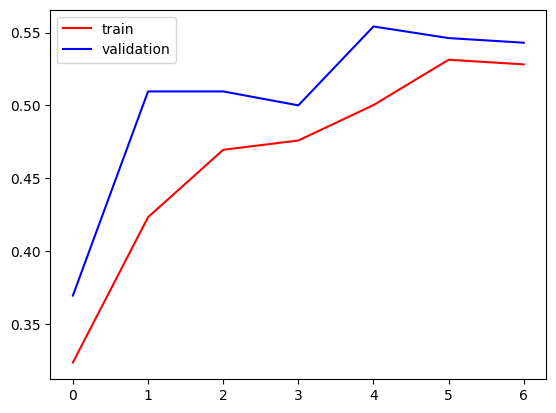

In [ ]:
# Accuracy
plt.plot(history_resnet.history['accuracy'],color='red',label='train')
plt.plot(history_resnet.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


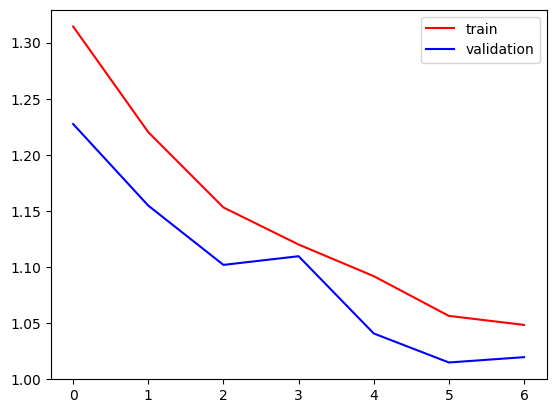

In [ ]:
#loss
plt.plot(history_resnet.history['loss'],color='red',label='train')
plt.plot(history_resnet.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# saving all my 3 models
best_vgg = load_model("/content/best_model_vg16.h5")
best_mobile = load_model("/content/MobileNet")
best_resnet = load_model("/content/Resnet")
best_scratch = load_model("/content/best_model.h5")

best_vgg.save("/content/drive/MyDrive/Colab Notebooks/best_model_vg16.h5")
best_mobile.save("/content/drive/MyDrive/Colab Notebooks/mobilenet.h5")
best_resnet.save("/content/drive/MyDrive/Colab Notebooks/resnet.h5")
best_scratch.save("/content/drive/MyDrive/Colab Notebooks/scratch.h5")

#Model Comparison

We are checking the classification metrics for all our 3 transfer learning models

for some reason resnet was not giving us good results but vgg16 and mobile net gave results on test with accuracy of upwards to 85 %

Lets check other classification metrics like f1 score , precision and recall

In [ ]:
#scratch model

# Make predictions on your test dataset using the generator
scratch=load_model("/content/drive/MyDrive/Colab Notebooks/scratch.h5")
predictions = scratch.predict(test_ds)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_labels = test_ds.labels

# Compute classification metrics
report = classification_report(true_labels, predicted_labels)
print(report)



11/11 [==============================] - 3s 251ms/step
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        81
           1       0.71      0.47      0.57        83
           2       0.61      0.78      0.68        81
           3       0.99      0.98      0.99       106

    accuracy                           0.79       351
   macro avg       0.78      0.77      0.77       351
weighted avg       0.79      0.79      0.78       351



In [ ]:
#VGG16


# Make predictions on your test dataset using the generator
model_res=load_model("/content/drive/MyDrive/Colab Notebooks/best_model_vg16.h5")
predictions = model_res.predict(test_ds)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_labels = test_ds.labels

# Compute classification metrics
report = classification_report(true_labels, predicted_labels)
print(report)



11/11 [==============================] - 3s 226ms/step
              precision    recall  f1-score   support

           0       0.96      0.81      0.88        81
           1       0.67      0.83      0.74        83
           2       0.81      0.74      0.77        81
           3       1.00      0.99      1.00       106

    accuracy                           0.85       351
   macro avg       0.86      0.84      0.85       351
weighted avg       0.87      0.85      0.86       351



In [ ]:
#MobileNet

# Make predictions on your test dataset using the generator
model_mob=load_model("/content/drive/MyDrive/Colab Notebooks/mobilenet.h5")
predictions = model_mob.predict(test_ds)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_labels = test_ds.labels

# Compute classification metrics
report = classification_report(true_labels, predicted_labels)
print(report)



11/11 [==============================] - 3s 200ms/step
              precision    recall  f1-score   support

           0       0.99      0.86      0.92        81
           1       0.73      0.95      0.83        83
           2       0.94      0.77      0.84        81
           3       1.00      1.00      1.00       106

    accuracy                           0.90       351
   macro avg       0.91      0.90      0.90       351
weighted avg       0.92      0.90      0.90       351



In [ ]:
#RESNET50
# Make predictions on your test dataset using the generator
model_res=load_model("/content/drive/MyDrive/Colab Notebooks/resnet.h5")
predictions = model_res.predict(test_ds)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_labels = test_ds.labels

# Compute classification metrics
report = classification_report(true_labels, predicted_labels)
print(report)



11/11 [==============================] - 3s 206ms/step
              precision    recall  f1-score   support

           0       0.76      0.36      0.49        81
           1       0.26      0.36      0.30        83
           2       0.32      0.26      0.29        81
           3       0.58      0.72      0.64       106

    accuracy                           0.44       351
   macro avg       0.48      0.42      0.43       351
weighted avg       0.49      0.44      0.44       351



#Further Improvements


We can try some other techniques to improve he accuracy even further
---> we can unfreeze some of the last layers of the best model and train further to get the maximum accuracy out


In [ ]:
model_temp=model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/mobilenet.h5')
model_temp.layers

In [ ]:
#the above shown are the layers for our best model giving 90 % accuracy in test data
model_temp.layers[0].layers
#lets check all the layers in our mobile net feature extractor.

In [ ]:
#Lets check the last 6 layers
model_temp.layers[0].layers[-5:]

In [ ]:
#lets unfreeze all the above layers
for i in model_temp.layers[0].layers[-5:]:
  i.trainable=True

In [ ]:
#check to check if they are now trainable
for layer in model_temp.layers[0].layers:
  print(layer.name,layer.trainable)

input_2 True
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False
conv_pw_8_relu Fa

In [ ]:
#the last 6 layers are trainable
#lets train the model further
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_pro.h5",monitor='val_loss', save_best_only=True)

history = model_temp.fit(train_ds, epochs=5, validation_data=validation_ds, callbacks=[early_stopping, checkpoint])


Epoch 1/5
79/79 [==============================] - 54s 687ms/step - loss: 0.0176 - accuracy: 0.9952 - val_loss: 0.0781 - val_accuracy: 0.9745
Epoch 2/5
79/79 [==============================] - 53s 668ms/step - loss: 0.0204 - accuracy: 0.9944 - val_loss: 0.0907 - val_accuracy: 0.9745
Epoch 3/5
79/79 [==============================] - 51s 642ms/step - loss: 0.0223 - accuracy: 0.9924 - val_loss: 0.0812 - val_accuracy: 0.9745
Epoch 4/5
79/79 [==============================] - 49s 623ms/step - loss: 0.0231 - accuracy: 0.9928 - val_loss: 0.0894 - val_accuracy: 0.9761


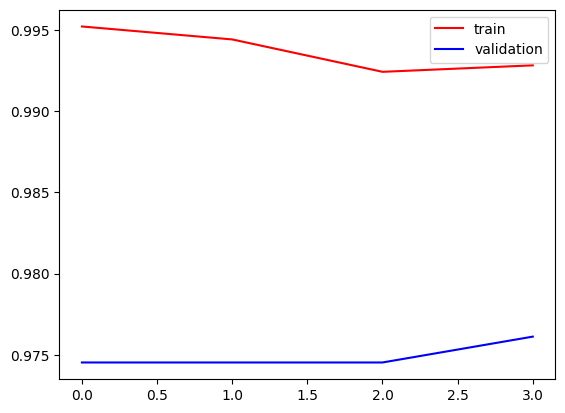

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


In [ ]:
model_temp.evaluate(test_ds)

11/11 [==============================] - 3s 246ms/step - loss: 0.4754 - accuracy: 0.8832


[0.47540175914764404, 0.8831908702850342]

In [ ]:
#refined mobilenet model
# Make predictions on your test dataset using the generator
model_temp.save("/content/drive/MyDrive/Colab Notebooks/mobile_pro.h5")
model_pro=load_model("/content/drive/MyDrive/Colab Notebooks/mobile_pro.h5")
predictions = model_pro.predict(test_ds)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_labels = test_ds.labels

# Compute classification metrics
report = classification_report(true_labels, predicted_labels)
print(report)



11/11 [==============================] - 2s 182ms/step
              precision    recall  f1-score   support

           0       0.99      0.84      0.91        81
           1       0.69      0.94      0.80        83
           2       0.92      0.72      0.81        81
           3       1.00      1.00      1.00       106

    accuracy                           0.88       351
   macro avg       0.90      0.87      0.88       351
weighted avg       0.91      0.88      0.89       351



From the above we can see that there is not any significant improvement even after un freezing 6 layers from the feature extraction so our best model still remains the mobile net base model with 90.5 percentage accuracy on the test set of 35 images

We can also see that the models perform best on the class 3 followed by class 1
lets see what the class 4 and 1 are:


In [ ]:
class_labels = {i:j for i,j in zip(test_ds.class_indices.keys(),test_ds.class_indices.values())}

# Print the class labels
print(pd.DataFrame(class_labels,index= ["intmap"]))

        indian market  onion  potato  tomato
intmap              0      1       2       3


As we can see that the model was 100 % accurate in detecting tomatoes and 91% accuracte in detecting markets there seems to be decreased performance for onion and potatoes we can create a confusion matrix for this to get a better idea


11/11 [==============================] - 4s 203ms/step


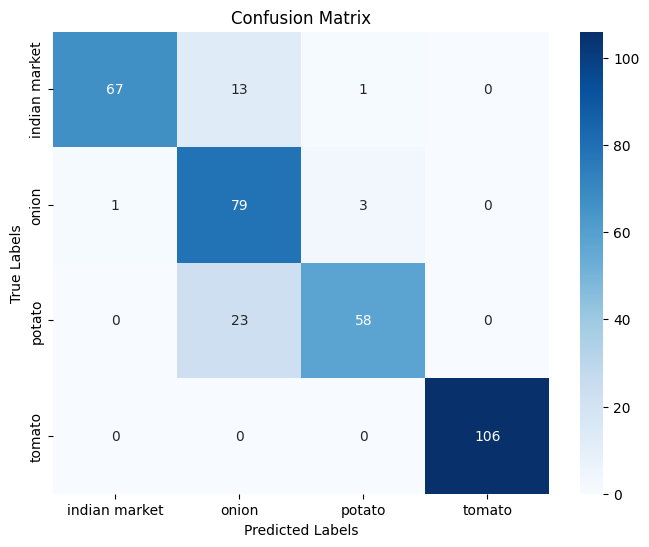

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset
y_pred = model_temp.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtain the true labels
true_labels = test_ds.classes

# Compute the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Define class labels
class_labels = list(test_ds.class_indices.keys()) # Replace with your class labels

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


11/11 [==============================] - 5s 357ms/step


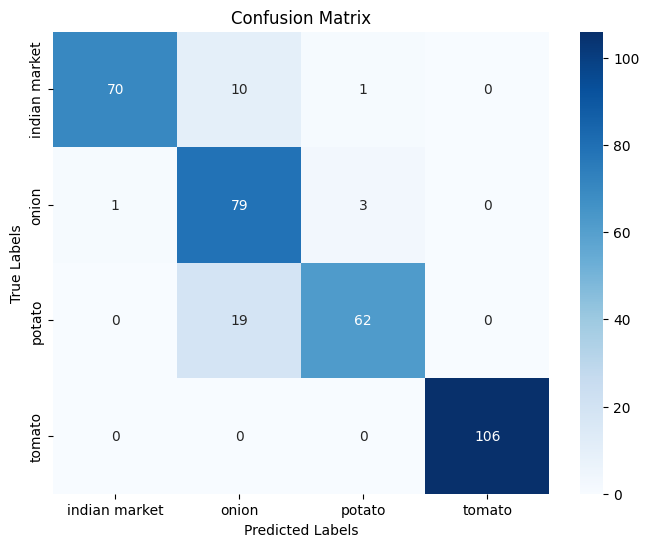

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset
y_pred = model_mob.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtain the true labels
true_labels = test_ds.classes

# Compute the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Define class labels
class_labels = list(test_ds.class_indices.keys()) # Replace with your class labels

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# the below shows the confusion matrix for our best model